2025-05-02 14:57:24.751343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746178044.771815   10923 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746178044.777773   10923 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/arun/tf_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746178075.815418   10923 gpu_device.cc:2022] Created device /job:localho

Epoch 1/20


I0000 00:00:1746178079.311638   11230 cuda_dnn.cc:529] Loaded cuDNN version 90300


1165/1165 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7808 - loss: 0.5818 - val_accuracy: 0.8263 - val_loss: 0.3903
Epoch 2/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8289 - loss: 0.3876 - val_accuracy: 0.8117 - val_loss: 0.3658
Epoch 3/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8512 - loss: 0.3457 - val_accuracy: 0.8982 - val_loss: 0.2942
Epoch 4/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8817 - loss: 0.3144 - val_accuracy: 0.8983 - val_loss: 0.2810
Epoch 5/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8953 - loss: 0.2955 - val_accuracy: 0.9009 - val_loss: 0.2782
Epoch 6/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8993 - loss: 0.2873 - val_accuracy: 0.9050 - val_loss: 0.2664
Epoch 7/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8999 - loss: 0.2821 - val_accuracy: 0.9067 - val_loss: 0.2515
Epoch 8/20
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9002 - loss: 0.2736 - val

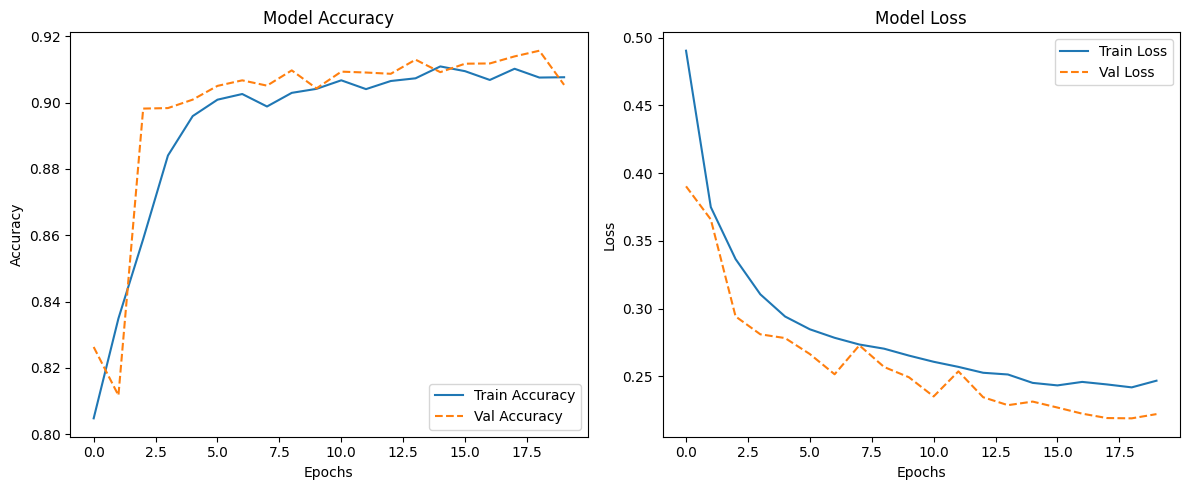

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

# Load dataset
train_file = "./datasets/UNSW_NB15_training-set.csv"
test_file = "./datasets/UNSW_NB15_testing-set.csv"

data_train = pd.read_csv(train_file)
data_test = pd.read_csv(test_file)

# Drop unnecessary column
data_train.drop(columns=['id'], inplace=True)
data_test.drop(columns=['id'], inplace=True)

# Use only Zeek-compatible features
selected_features = [
    'proto', 'service', 'state',
    'dur', 'sbytes', 'dbytes',
    'spkts', 'dpkts',
    'label'
]

data_train = data_train[selected_features]
data_test = data_test[selected_features]

# Encode categorical fields
categorical_cols = ['proto', 'service', 'state']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data_train[col] = le.fit_transform(data_train[col])
    data_test[col] = data_test[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    label_encoders[col] = le

# Save label encoders
with open("label_encoders_multiclass.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

# Convert to float
data_train = data_train.astype(np.float32)
data_test = data_test.astype(np.float32)

# Extract features and labels
X_train = data_train.drop(columns=['label']).values
X_test = data_test.drop(columns=['label']).values
y_train = data_train['label'].values
y_test = data_test['label'].values

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save scaler
with open("scaler_multiclass.pkl", "wb") as f:
    pickle.dump(scaler, f)

# One-hot encode labels
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Train-validation split
X_train, X_val, y_train_cat, y_val_cat = train_test_split(
    X_train, y_train_cat, test_size=0.15, random_state=42, shuffle=True
)

# Reshape input
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Model definition
def build_multiclass_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.5),
        GRU(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        GRU(32, kernel_regularizer=l2(0.001)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Class weights
y_labels_flat = np.argmax(y_train_cat, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels_flat),
    y=y_labels_flat
)
class_weights_dict = dict(enumerate(class_weights))

# Build and train model
model = build_multiclass_model((X_train.shape[1], X_train.shape[2]), num_classes)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,
    batch_size=128,
    shuffle=True,
    class_weight=class_weights_dict,
    verbose=1
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"\nTest Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# Save model
model.save("cnn_gru_conn_dns_ssl_multiclass.keras")

# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.savefig("training_plot_conn_dns_ssl_multiclass.png")
plt.show()
